# BioscrapeCOBRA: a multi-paradigm composite of FBA, CRN, and physics engine

Vivarium is a powerful tool for combining previously-isolated frameworks in computational biology.
This notebook demonstrates the integration of flux balance analysis (FBA), chemical reaction networks (CRNs), and a physics engine, to simulate many individual cells in a spatial environment.


Processes include:
* Bioscrape
* COBRA
* Multibody (pymunk)

Processes accept standard formats:
* SBML
* BiGG model

In [1]:
#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.22
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

# assert correct library versions are loaded
#from importlib.metadata import version
#assert version('vivarium-core') == '0.1.11'
#assert version('vivarium-cobra') == '0.0.7'
#assert version('vivarium-bioscrape') == '0.0.0.5'
#assert version('vivarium-multibody') == '0.0.4'

'\n%%capture\n!pip install git+https://github.com/vivarium-collective/vivarium-notebooks\n!pip install vivarium-core==0.1.22\n!pip install vivarium-cobra==0.0.6\n!pip install vivarium-pymunk==0.0.2\n!pip install vivarium-bioscrape\n'

In [2]:
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, 
    Deriver, 
    Composer,
)
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# helper functions for composition
from vivarium.core.composition import (
    process_in_experiment,
    simulate_composer,
    composer_in_experiment,
    compose_experiment,
    COMPOSER_KEY,
)

# vivarium plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, 
    plot_variables, 
    save_fig_to_dir,
)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# vivarium-core processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

# The three paradigms on their own

## **Paradigm 1**: Flux Balance Analysis with COBRA

[Constraint-based reconstruction and analysis (COBRA)](https://cobrapy.readthedocs.io/en/latest/) is a popular FBA solver.

The [vivarium-cobra library](https://github.com/vivarium-collective/vivarium-cobra) provides a Vivarium wrapper process for COBRA:
 ```
 pip install vivarium-cobra
 ```
 
* The COBRA process can load [BiGG metabolic models](http://bigg.ucsd.edu) -- over 100 models are available, including dozens of *E. coli* strains. 
* Here, *iAF1260b* is loaded, which has 2382 reactions, 1261 genes, and 166 metabolites.
* The objective function, with 67 molecules, is stored in internal pools. There are 299 external molecules -- of these, 19 show dynamics in minimal glucose conditions.

In [119]:
# vivarium-cobra processes
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)

# set cobra constrained reactions config
cobra_config = get_iAF1260b_config()

# plotting
tags_dict = {
    'glc__D_e': 'tab:cyan',
    'co2_e': 'tab:orange',
    'h2o_c': 'tab:cyan',
    'atp_c': 'tab:orange',
    'asp__L_c': 'tab:green'
}

def move_to_end(data, d):
    for key in d.keys():
        if key in data:
            data[key] = data.pop(key)
    return data

def plot_metabolism(data, tags=tags_dict):

    # initialize subplots
    n_rows = 3
    n_cols = 1
    fig = plt.figure(figsize=(n_cols * 8, n_rows * 2))
    grid = plt.GridSpec(n_rows, n_cols)

    time_vec = data['time']

    # external
    ax = fig.add_subplot(grid[0, 0])
    external = move_to_end(data['external'], tags)
    for mol_id, series in external.items():
        if sum(series) != 0.0:
            ax.plot(
                time_vec, 
                series, 
                label=mol_id if mol_id in tags else None, 
                color=tags.get(mol_id,'tab:gray'),
            )
    ax.set_title(f'external ({len(external.keys())} species)')
    ax.set_ylabel('concentrations (mmol)')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # internal
    ax = fig.add_subplot(grid[1, 0])
    internal = move_to_end(data['internal_counts'], tags)
    for mol_id, series in internal.items():
        if sum(series) != 0.0:
            ax.plot(
                time_vec, 
                series, 
                label=mol_id if mol_id in tags else None, 
                color=tags.get(mol_id,'tab:gray'),
            )
    ax.set_title(f'internal ({len(internal.keys())} species)')
    ax.set_ylabel('counts')
    ax.set_yscale('log')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    # mass
    ax = fig.add_subplot(grid[2, 0])
    ax.plot(
        time_vec, 
        data['global'][('mass', 'femtogram')], 
        color='tab:blue',
    )
    ax.set_title('global')
    ax.set_ylabel('total mass (fg)')
    ax.set_xlabel('time (sec)')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    fig.tight_layout()   
    return fig

### run COBRA process

In [4]:
# get the configuration for the iAF1260b BiGG model
config = get_iAF1260b_config()
config.update({'time_step': 10})
iAF1260b_config = {'cobra': config}   

# load iAF1260b into CobraComposite
dynamic_fba = CobraComposite(iAF1260b_config)

# get the initial state
initial_state = dynamic_fba.initial_state({}) 

# run simulation
cobra_sim_settings = {
    'initial_state': initial_state,
    'total_time': 2000}
cobra_timeseries = simulate_composer(dynamic_fba, cobra_sim_settings)


Experiment ID: 597b2f32-6cd4-11eb-8e0b-acde48001122
Created: 02/11/2021 at 17:48:05
Completed in 25.09 seconds


### plot COBRA output

In [79]:
external = [key for key, series in cobra_timeseries['external'].items() if sum(series) != 0]
print(f"EXTERNAL: {external}")

internal = [key for key, series in cobra_timeseries['internal_counts'].items() if sum(series) != 0]
print(f"INTERNAL: {internal}")

EXTERNAL: ['cl_e', 'co2_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h2o_e', 'h_e', 'glc__D_e', 'k_e', 'pi_e', 'mg2_e', 'mn2_e', 'mobd_e', 'nh4_e', 'so4_e', 'o2_e', 'zn2_e', 'ca2_e']
INTERNAL: ['10fthf_c', '2ohph_c', 'ala__L_c', 'amet_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'ca2_c', 'cl_c', 'coa_c', 'cobalt2_c', 'ctp_c', 'cu2_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'fad_c', 'fe2_c', 'fe3_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'k_c', 'kdo2lipid4_e', 'leu__L_c', 'lys__L_c', 'met__L_c', 'mg2_c', 'mlthf_c', 'mn2_c', 'mobd_c', 'murein5px4p_p', 'nad_c', 'nadp_c', 'nh4_c', 'pe160_c', 'pe160_p', 'pe161_c', 'pe161_p', 'phe__L_c', 'pheme_c', 'pro__L_c', 'pydx5p_c', 'ribflv_c', 'ser__L_c', 'sheme_c', 'so4_c', 'thf_c', 'thmpp_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'udcpdp_c', 'utp_c', 'val__L_c', 'zn2_c']


volume growth: 1.708809161242802
mass growth: 1.708809161242802
Writing out/cobra_output.pdf


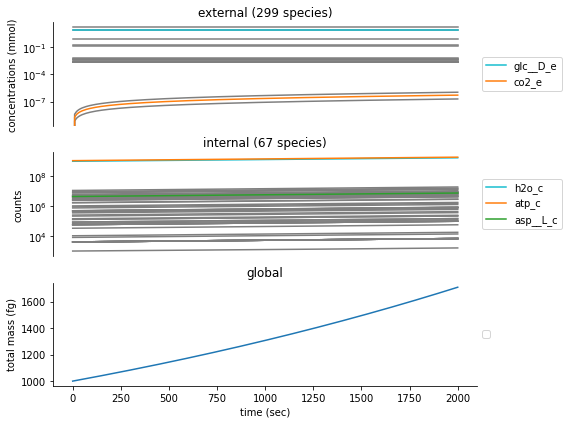

In [120]:
print_growth(cobra_timeseries['global'])
fig = plot_metabolism(cobra_timeseries)
save_fig_to_dir(fig, 'cobra_output.pdf')

## **Paradigm 2**: Chemical Reaction Network with Bioscrape

Bioscrape is an easily extensible and modular object-oriented framework for building and simulating CRNs. Bioscrape Process loads Systems Biology Markup Language (SBML) files.

The [vivarium-bioscrape library](https://github.com/vivarium-collective/vivarium-bioscrape) provides a Vivarium wrapper process for Bioscrape:
 ```
 pip install vivarium-bioscrape
 ```

In [6]:
# vivarium-bioscrape processes
from vivarium_bioscrape.processes.bioscrape import Bioscrape

SBML_FILE_DETERMINISTIC = 'LacOperon_deterministic.xml'
SBML_FILE_STOCHASTIC = 'LacOperon_stochastic.xml'

#choose the SBML file and set other bioscrape parameters
deterministic_bioscrape_config = {
            'sbml_file': SBML_FILE_DETERMINISTIC,
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
}

stochastic_bioscrape_config = {
            'sbml_file': SBML_FILE_STOCHASTIC,
            'stochastic': True,
            'safe_mode': False,
            'initial_volume': 1,
            'internal_dt': 0.1,
}

# global configs
plotted_bioscrape_variables = {
    'variables':[
        ('species', 'Glucose_external'), 
        ('species', 'Lactose_external'), 
        ('species', 'rna_M'), 
        ('species', 'protein_betaGal'),
        ('species', 'protein_Lactose_Permease')
        ]}

### run Bioscrape Process with deterministic simulator

In [7]:
# initialize Bioscrape process
total_time = 2500
time_step = 10

#This will configure a deterministic model as a system of ODEs
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
            'time_step':time_step}
deterministic_process = Bioscrape(deterministic_bioscrape_config)

# get initial state
initial_state = deterministic_process.initial_state()

# make an experiment
deterministic_experiment = process_in_experiment(deterministic_process, initial_state=initial_state)

# run the experiment
deterministic_experiment.update(total_time)


Experiment ID: 6a57434a-6cd4-11eb-8e0b-acde48001122
Created: 02/11/2021 at 17:48:33
Completed in 0.225129 seconds


### plot deterministic Bioscrape output

Writing out/bioscrape_deterministic.pdf


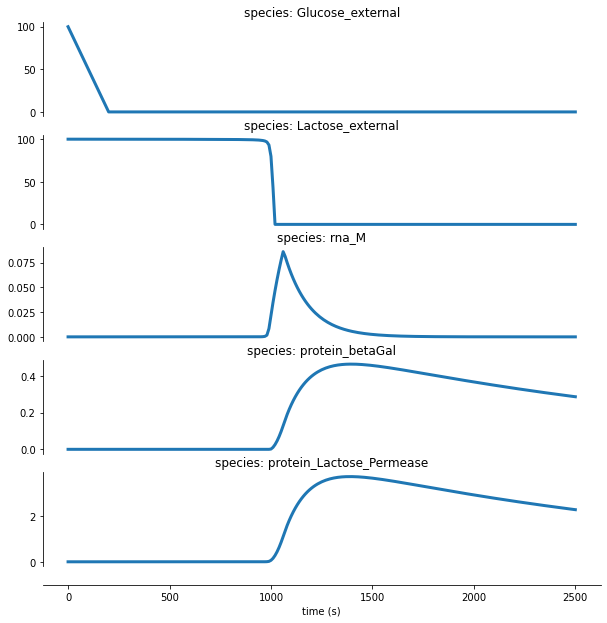

In [8]:
# retrieve the data
deterministic_timeseries = deterministic_experiment.emitter.get_timeseries()

# plot output
deterministic_plot_config = {
    'filename': 'bioscrape_deterministic.pdf',
    **plotted_bioscrape_variables,
    **plot_var_config}
fig = plot_variables(deterministic_timeseries, **deterministic_plot_config)


### run Bioscrape Process with stochastic simulator

In [125]:
#Run the simulation
total_time = 5000

bioscrape_process_stochastic = Bioscrape(stochastic_bioscrape_config)

# initial state
initial_state = bioscrape_process_stochastic.initial_state()
# print(initial_state)

# make an experiment
stochastic_experiment = process_in_experiment(bioscrape_process_stochastic, initial_state=initial_state)

# run the experiment
stochastic_experiment.update(total_time)



Experiment ID: 1015fff6-6d57-11eb-8e0b-acde48001122
Created: 02/12/2021 at 09:23:46
Completed in 7.13 seconds


### plot stochastic Bioscrape output

<font color='red' size="6">
TODO: <br>
&ensp;    * what is up with this behavior?
    <br><br>
</font

Writing out/bioscrape_stochastic.pdf


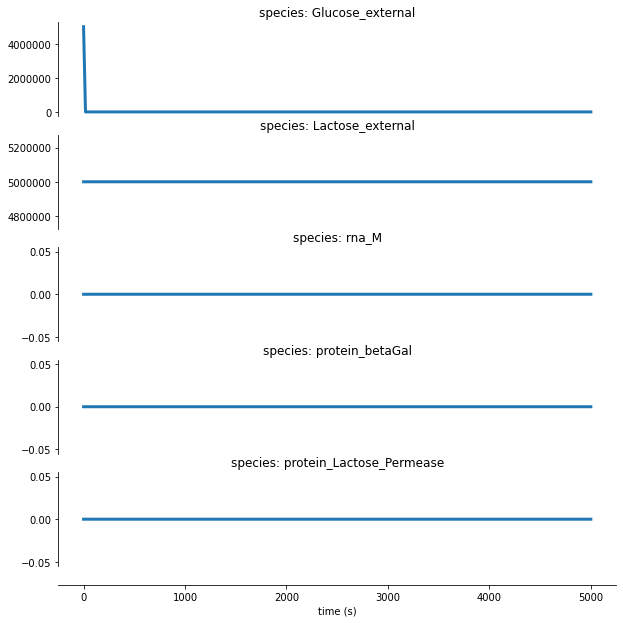

In [126]:
# retrieve the data
stochastic_timeseries = stochastic_experiment.emitter.get_timeseries()

# plot output
stochastic_plot_config = {
    'filename': 'bioscrape_stochastic.pdf',
    **plotted_bioscrape_variables,
    **plot_var_config}
fig = plot_variables(stochastic_timeseries, **stochastic_plot_config)

## **Paradigm 3**: Multibody physics with pymunk
[pymunk](multibody) is an open-source video game physics engine.
[vivarium-multibody](https://github.com/vivarium-collective/vivarium-multibody) provides a Vivarium wrapper process for pymunk, configured specifically for multi-cellular physics:
 ```
 pip install vivarium-multibody
 ```

In [112]:
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import agent_body_config, volume_from_length
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors,
)
from vivarium_multibody.plots.snapshots import plot_tags
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets


def make_interactive(multibody_data):

    multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

    # make the snapshot plot function
    time_vec = list(multibody_agents.keys()) 

    # get fields and agent colors
    multibody_field_range = get_field_range(multibody_fields, time_vec)
    multibody_agent_colors = get_agent_colors(multibody_agents)

    time_index_range = len(time_vec) -1

    def plot_single_snapshot(t_index):   
        time_indices = np.array([t_index])
        snapshot_time = [time_vec[t_index]]
        fig = make_snapshots_figure(
            time_indices=time_indices,
            snapshot_times=snapshot_time,
            agents=multibody_agents,
            agent_colors=multibody_agent_colors,
            fields=multibody_fields,
            field_range=multibody_field_range,
            n_snapshots=1,
            bounds=spatial_bounds,
            default_font_size=12,
            plot_width=7)
        
    interactive_plot = interactive(
        plot_single_snapshot, 
        t_index=widgets.IntSlider(min=0, max=time_index_range, step=2, value=0))
    
    return interactive_plot


In [110]:
total_time = 140
n_agents = 3
spatial_bounds = [70, 70]

# configure
agent_ids = [str(agent_id) for agent_id in range(n_agents)]
body_config = {'bounds': spatial_bounds, 'agent_ids': agent_ids}
multibody_config = {'bounds': spatial_bounds}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4,1),
        total_time=total_time,
        experiment_settings=experiment_settings)


### interactive plot of multibody physics

In [115]:
interactive_plot = make_interactive(multibody_data)


In [116]:
interactive_plot

interactive(children=(IntSlider(value=0, description='t_index', max=140, step=2), Output()), _dom_classes=('wi…

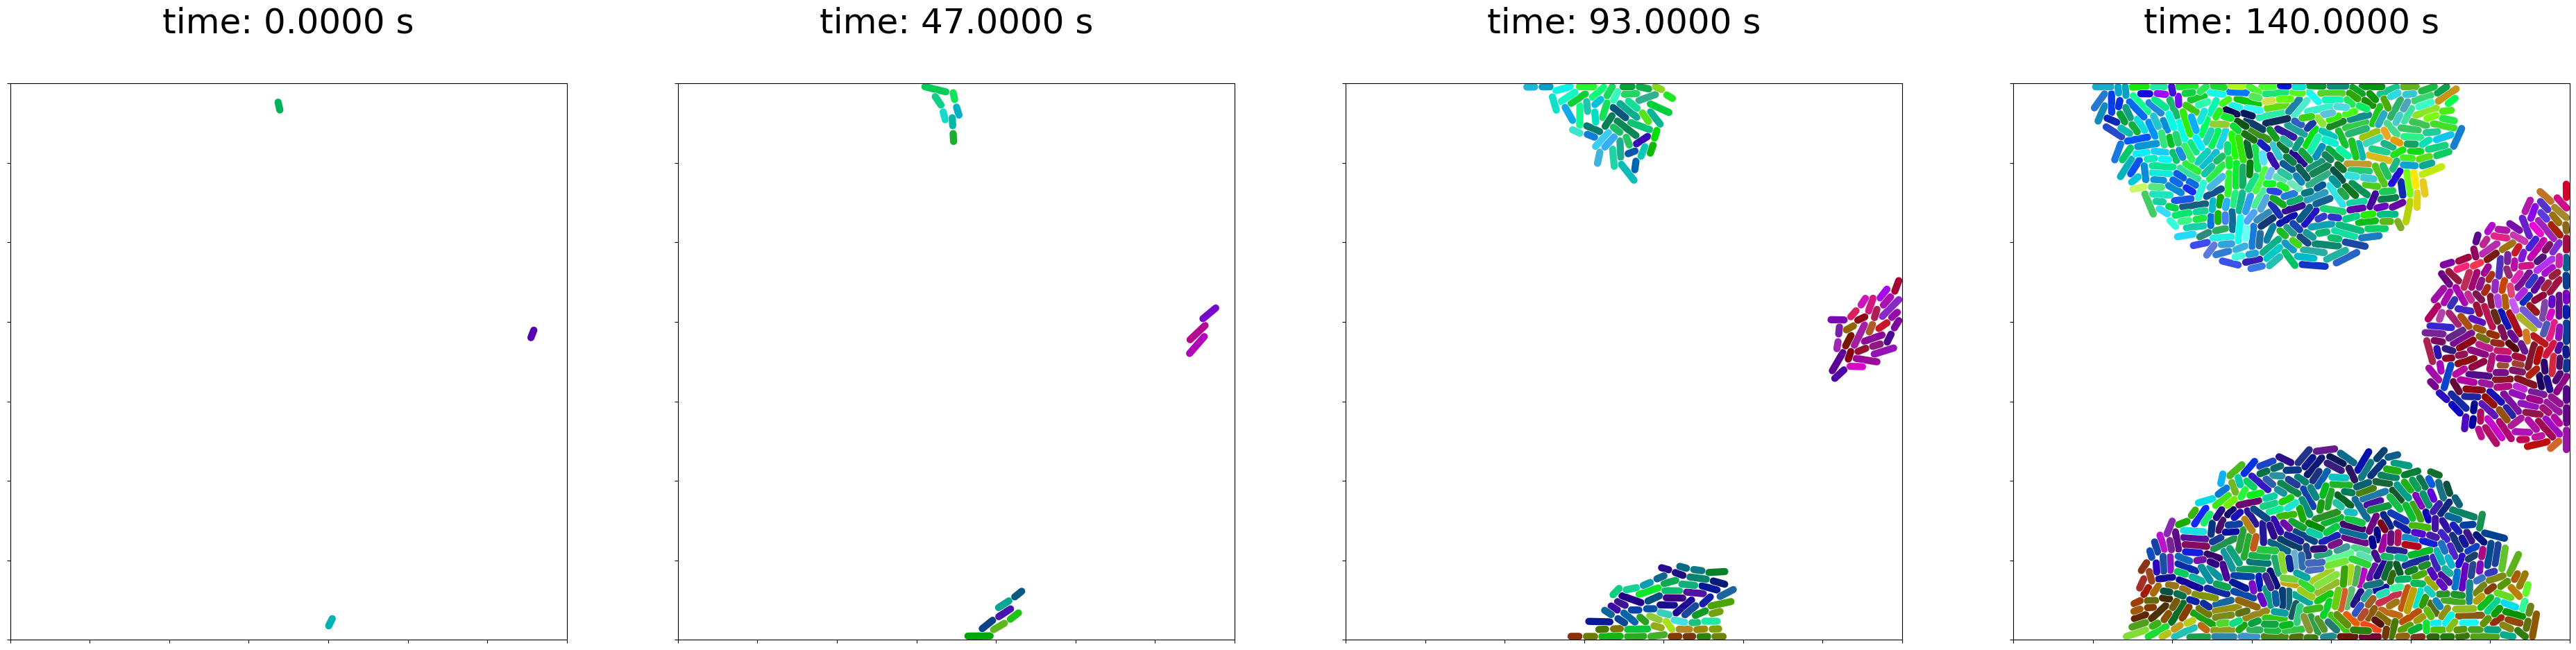

In [124]:
agents, fields = format_snapshot_data(multibody_data)
plot_snapshots(
    bounds=spatial_bounds,
    agents=agents,
    fields=fields,
    n_snapshots=4,
    out_dir='out',
    filename='multibody_snapshots.pdf',
    )

# BioscrapeCOBRA auxiliary processes 

* Connecting different Processes may require additional auxiliary 'helper' Processes to make conversions and adapt each process' unique definitions.
* Derivers are a subclass of Process that runs after the other dynamic Processes and derives some states from others.

Included auxiliary processes:
* FluxAdaptor
* BiomassAdaptor: this processes demonstrates vivarium units

In [14]:
from vivarium.processes.clock import Clock
from vivarium_cobra.processes.local_field import LocalField

## Flux Adaptor

An adaptor is a Process which can be used to convert values of one store into another type of value in another store. For example, this FluxAdaptor converts amounts of species and changes in amounts of species to instantaneous fluxes.

This FluxAdaptor is used in the composite to convert the changes of Lactose and Glucose from the CRN model into flux-bounds for the FBA model. In these cases "deltas" (changes in Species) are converted to fluxes by dividing by the timestep.

This FluxAdaptor is also used to convert changes in biomass, output from the FBA model, into a dilution rate constant used by the CRN. This flux is computered differently because the change in biomass each timestep is not stored. Additionally, dilution rate must be calculated as a percentage of the current amount, not absolute flux, and be non-negative.

In [15]:
from vivarium.core.process import Process


class FluxAdaptor(Process):
    """ Bioscrape delta species to fluxes for constraining COBRA """

    defaults = {
        'time_step': 1.0,
        'flux_keys': {},  # key --> {option dictionary}
        'default_options': {  # default options if option_dictionary is empty
            "input_type": "delta",
            # "delta" corresponds to changes between timesteps. "amount" corresponds to the absolute quantity
        }
    }

    def __init__(self, config=None):
        super().__init__(config)

        self.prev_inputs = {k: None for k in self.parameters["flux_keys"]}

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'inputs': {
                flux_key: {
                    '_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {
                    '_updater': 'set',
                    '_emit': True}
                for flux_key in self.parameters['flux_keys']
            }
        }

    def compute_flux(self, flux_key, dt, inputs):
        # computes the flux for a specific flux key of the time interval dt

        input_type = self.parameters['flux_keys'][flux_key].get("input_type",
                                                                self.parameters['default_options']["input_type"])

        # Set delta
        if input_type == "delta":
            delta = inputs[flux_key]
        elif input_type == 'amount':
            if self.prev_inputs[flux_key] is None:
                delta = 0
            else:
                delta = inputs[flux_key] - self.prev_inputs[flux_key]
        else:
            raise ValueError(f"Unknown input_type: {input_type} for flux_key {flux_key}")

        return delta / dt

    def next_update(self, timestep, states):
        inputs = states["inputs"]

        update = {}
        update['fluxes'] = {}

        for flux_key in self.parameters['flux_keys']:
            # flux_dt = self.get_flux_interval(flux_key, timestep)
            # if flux_dt is not None:
            update['fluxes'][flux_key] = self.compute_flux(flux_key, timestep, inputs)

        self.prev_inputs = inputs
        return update


class DilutionFluxAdaptor(FluxAdaptor):
    """
    This is a non-negative "percentage" flux used to control a dilution rate of a CRN from a the rate of growth in biomass
    """
    
    def next_update(self, timestep, states):
        inputs = states["inputs"]

        update = {}
        update['fluxes'] = {}

        for flux_key in self.parameters['flux_keys']:
            flux = self.compute_flux(flux_key, timestep, inputs)

            # Convert to a percent of the previous input
            if self.prev_inputs[flux_key] is None or (
                    self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] == 0):
                # Edge case: If both the current amount and the previous amount were 0, return 0
                update['fluxes'][flux_key] = 0

            elif self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] > 0:
                # Edge case: If both the previous amount was 0, us the current amount for the normalization
                update['fluxes'][flux_key] = flux / states["inputs"][flux_key]

            else:
                # Standard case
                update['fluxes'][flux_key] = flux / self.prev_inputs[flux_key]

            # Enforce non-negativity
            if update['fluxes'][flux_key] < 0:
                update['fluxes'][flux_key] = 0

        self.prev_inputs = inputs
        return update


class AverageFluxAdaptor(FluxAdaptor):
    """
    This is similar to a FluxAdaptor, but fluxes are averaged between updates. This is useful to compute fluxes
    which are used by a process with a larger dt than the processes controlling the flux, for example a stochastic
    CRN may be updated frequently but FBA may be updated less frequently.
    """

    defaults = {
        'time_step': 1.0,
        'flux_keys': {},  # key --> {option dictionary}
        'default_options': {  # default options if option_dictionary is empty
            "input_type": "delta", # "delta" corresponds to changes between timesteps. "amount" corresponds to the absolute quantity
            "window_size": 10 #Corresponds to the number of timesteps to average over
        }
    }
    
    def __init__(self, config=None):
        super().__init__(config)

        #Stores a list of previously computed fluxes
        self.prev_fluxes = {k:[] for k in self.parameters["flux_keys"]}

    def next_update(self, timestep, states):
        inputs = states["inputs"]

        update = {}
        update['fluxes'] = {}

        for flux_key in self.parameters['flux_keys']:
            window_size = self.parameters['flux_keys'][flux_key].get("window_size",
                                                                self.parameters['default_options']["window_size"])
            # flux_dt = self.get_flux_interval(flux_key, timestep)
            # if flux_dt is not None:
            flux = self.compute_flux(flux_key, timestep, inputs)
            self.prev_fluxes[flux_key].append(flux)
            
            #Compute the average fluxes
            if len(self.prev_fluxes[flux_key]) < window_size:
                update["fluxes"][flux_key] = sum(self.prev_fluxes[flux_key])/len(self.prev_fluxes[flux_key])
            else:
                update["fluxes"][flux_key] = sum(self.prev_fluxes[flux_key][-window_size:])/window_size

        self.prev_inputs = inputs
        return update


## BiomassAdaptor Deriver

This adaptor is used to do unit conversion between the mass output from cobra and a Species used in the Bioscrape model to represent biomass.

<font color='red' size="6">
TODO: <br>
&ensp;    * pull mass adaptors into vivarium-core
    <br><br>
</font

In [16]:
class mass_to_concentration(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units': 1.0 * units.fg,
        'input_volume_units': 1.0 * units.fL,
        'output_concentration_units': 1.0 * units.mmolar,
        'characteristic_output_volume': 1.0 * units.fL,
        'mass_species_molecular_weight': 1.0 * units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * self.parameters["input_mass_units"],
                },
                'volume': {
                    '_default': 1.0 * self.parameters["input_volume_units"]}
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #Concentration = mass/molecular_weight/characteristic volume
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_conc = mass/self.config['mass_species_molecular_weight']/(self.config['characteristic_output_volume'])        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_conc.to(self.config['output_concentration_units']).magnitude
                }
            }
        return update

class mass_to_count(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units': 1.0 * units.fg,
        'mass_species_molecular_weight': 1.0 * units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * units.fg,
                },
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #count = mass/molecular_weight
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_count = mass/self.config['mass_species_molecular_weight']        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_count.magnitude
                }
            }
        return update

# Integration: BioscrapeCOBRA

## BioscrapeCOBRA configurations

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

TODO:
    * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
    * import of Glucose is also in terms of 'Biomass' species
    * stochastically, it is in counts. Volume
    * logic for counts/concentrations if stochastic/deterministic
    * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        But don't let Bioscrape update them. Only use FBA's resulting uptake.


In [17]:

#set up the config for the FluxAdaptor
flux_config = {
    'flux_keys': {
        'Lactose_consumed': {'input_type':'delta'}, #No options specified
        'Glucose_internal': {'input_type':'delta'},  #No options specified
    },
}

dilution_rate_flux_config = {
    'flux_keys': {
        'biomass': {
            'input_type': 'amount'
        }
    }
}

#Here we override the default ports schema of the Biomass species and the k_dilution rate in Bioscrape.
#This is done so they can be set by the Derivers connected to mass and mass flux from Cobra.
schema_override = {
    'bioscrape': {
        'species': {
            'Biomass': {
                '_updater': 'set'  #override bioscrape ('species', 'Biomass') with a 'set' updater
            }
        },
        'rates':{
            'k_dilution__': {
                '_emit': True,  #k_dilution should be emitted so it can be plotted
                '_updater': 'set',
            }
        }
    }
}

<font color='red' size="6">
TODO: <br>
&ensp;    * Connect Bioscrape species 'external_*' to fields
    <br><br>
</font

In [26]:
class BioscrapeCOBRA(Composer):
    defaults = {
        'bioscrape_deterministic': deterministic_bioscrape_config,
        'bioscrape_stochastic': stochastic_bioscrape_config,
        'cobra': cobra_config,
        'flux_adaptor': flux_config,
        'dilution_rate_flux': dilution_rate_flux_config,
        'divide_on': False,  # is division turned on?
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2000 * units.fg},
        'boundary_path': ('boundary',),
        'agents_path': ('agents',),
        'fields_path': ('fields',),
        'dimensions_path': ('dimensions',),
        'daughter_path': tuple(),
        '_schema': schema_override,
        'stochastic': False,  # Is the CRN stochastic or deterministic?
        'spatial_on': False,  # are spatial dynamics used?
        'bioscrape_timestep': 1,
        'cobra_timestep': 10,
        'clock': {
            'time_step': 1.0}
    }

    def __init__(self, config=None):
        super().__init__(config)
        self.config['dilution_rate_flux']['time_step'] = self.config['cobra_timestep']
        self.config['flux_adaptor']['time_step'] = self.config['bioscrape_timestep']

    def generate_processes(self, config):
        processes = {
            'cobra': DynamicFBA(config['cobra']),
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
            'clock': Clock(config['clock']),
        }

        # Process Logic for different kinds of simulations

        # Deterministic case
        if not config['stochastic']:
            # create a deterministic bioscrape model
            processes['bioscrape'] = Bioscrape(config['bioscrape_deterministic'])

            # deterministic simulations have a variable dilution rate
            processes['dilution_rate_adaptor'] = DilutionFluxAdaptor(config["dilution_rate_flux"])

            # flux is computed as an instaneous flux
            processes['flux_adaptor'] = FluxAdaptor(config['flux_adaptor'])

            # biomass is converted to a concentration
            processes['biomass_adaptor'] = mass_to_concentration()

        # Stochastic Case
        else:
            # create a stochastic bioscrape model
            processes['bioscrape'] = Bioscrape(config['bioscrape_stochastic'])

            # flux is computed as an average flux
            processes['flux_adaptor'] = AverageFluxAdaptor(config['flux_adaptor'])

            # biomass is converted to a molecular count
            processes['biomass_adaptor'] = mass_to_count()

        # Division Logic
        if config['divide_on']:
            # division config
            daughter_path = config['daughter_path']
            agent_id = config['agent_id']
            division_config = dict(
                config.get('division', {}),
                daughter_path=daughter_path,
                agent_id=agent_id,
                composer=self)

            processes.update({
                'divide_condition': DivideCondition(config['divide_condition']),
                'division': MetaDivision(division_config)
            })

        # Spatial logic
        if config["spatial_on"]:
            processes.update({'local_field': LocalField()})

        return processes

    def generate_topology(self, config):
        agents_path = config['agents_path']
        fields_path = config['fields_path']
        dimensions_path = config['dimensions_path']
        boundary_path = config['boundary_path']

        topology = {
            'bioscrape': {
                # all species go to a species store on the base level,
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..',) + boundary_path + ('biomass',),
                },
                'delta_species': ('delta_species',),
                'rates': {
                    '_path': ('rates',),
                },
                'globals': boundary_path,
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': boundary_path + ('external',),
                'exchanges': boundary_path + ('exchange',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': boundary_path,
            },
            'flux_adaptor': {
                'inputs': ('delta_species',),
                # 'amounts': boundary_path,
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'

                'fluxes': {
                    '_path': ('flux_bounds',),
                    'Lactose_consumed': ('EX_lac__D_e',),
                    'Glucose_internal': ('EX_glc__D_e',),
                }
            },

            'mass_deriver': {
                'global': boundary_path,
            },
            'volume_deriver': {
                'global': boundary_path,
            },
            'biomass_adaptor': {
                'input': boundary_path,
                'output': boundary_path,
            },
            'clock': {
                'global_time': boundary_path + ('time',)
            }
        }

        # Ports added only in the deterministic case
        if not config['stochastic']:
            # Create port biomass flux to the dilution rate computed by the dilution_rate_adaptor process
            topology['dilution_rate_adaptor'] = {
                'inputs': boundary_path,
                'fluxes': {
                    '_path': ('rates',),
                    'biomass': ('k_dilution__',)
                }
            }

        # Ports added only in the stochastic case
        else:
            pass

        if config['divide_on']:
            # connect divide_condition to the mass variable
            topology.update({
                'divide_condition': {
                    'variable': boundary_path + ('mass',),
                    'divide': boundary_path + ('divide',),
                },
                'division': {
                    'global': boundary_path,
                    'agents': agents_path,
                },
            })

        # Ports to use in the spatial case
        if config["spatial_on"]:
            topology.update({'local_field': {
                'exchanges': boundary_path + ('exchange',),
                'location': boundary_path + ('location',),
                'fields': fields_path,
                'dimensions': dimensions_path,
            }})

        return topology

## Deterministic BioscrapeCOBRA

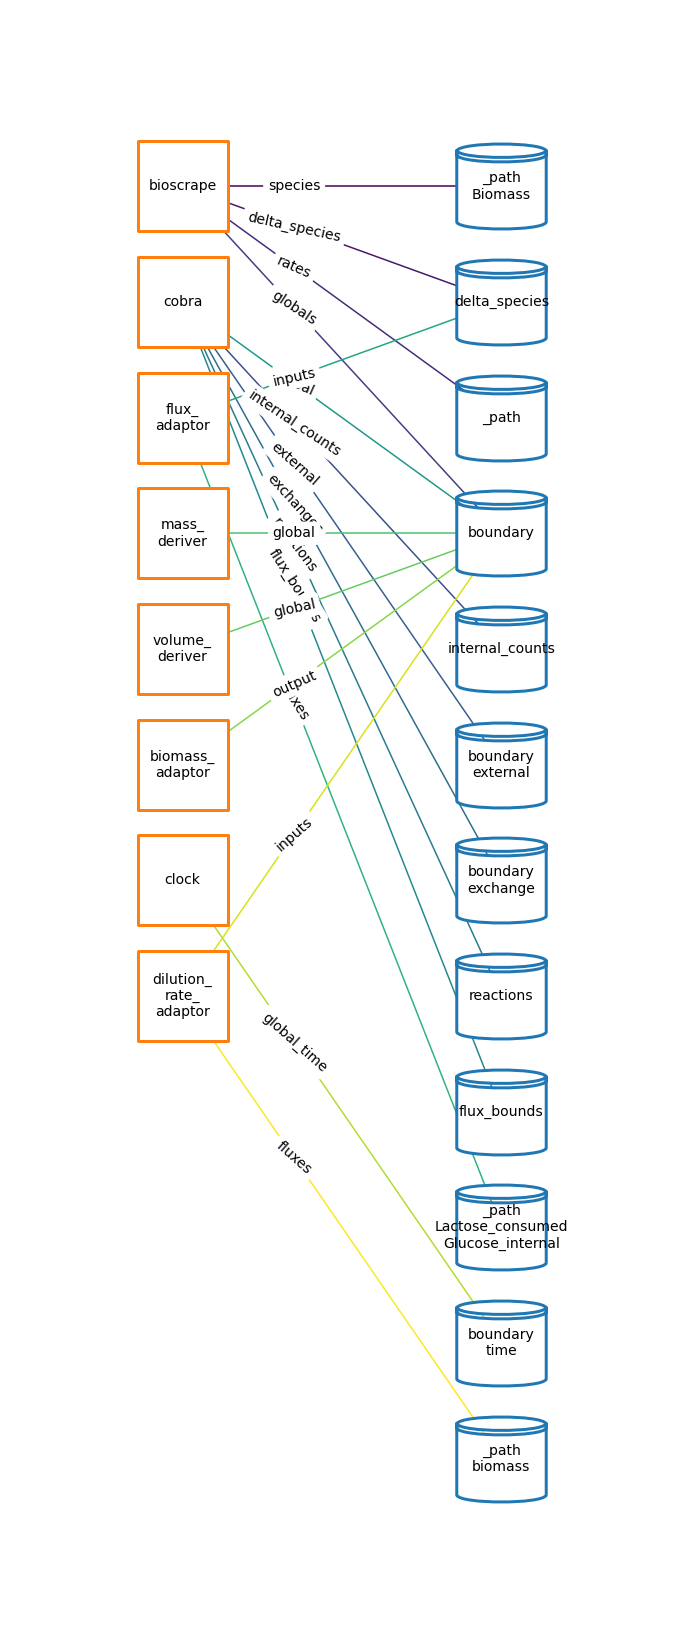

In [27]:
from vivarium.plots.topology import plot_compartment_topology

bioscrape_composer = BioscrapeCOBRA({})
fig = plot_compartment_topology(bioscrape_composer)


In [28]:
total_time = 2000
initial_state = bioscrape_composer.initial_state()
#initial_state['species']['Glucose_external'] = 100
#initial_state['species']['Lactose_external'] = 100

# make experiment
bioscrape_composite = bioscrape_composer.generate()
bioscrape_cobra_experiment = Experiment(
    dict(
        processes=bioscrape_composite['processes'],
        topology=bioscrape_composite['topology'],
        initial_state=initial_state))

bioscrape_cobra_experiment.update(total_time)


Experiment ID: 036bab34-6cd5-11eb-8e0b-acde48001122
Created: 02/11/2021 at 17:52:50


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 44.75 seconds


Writing out/deterministic_biocobra.pdf


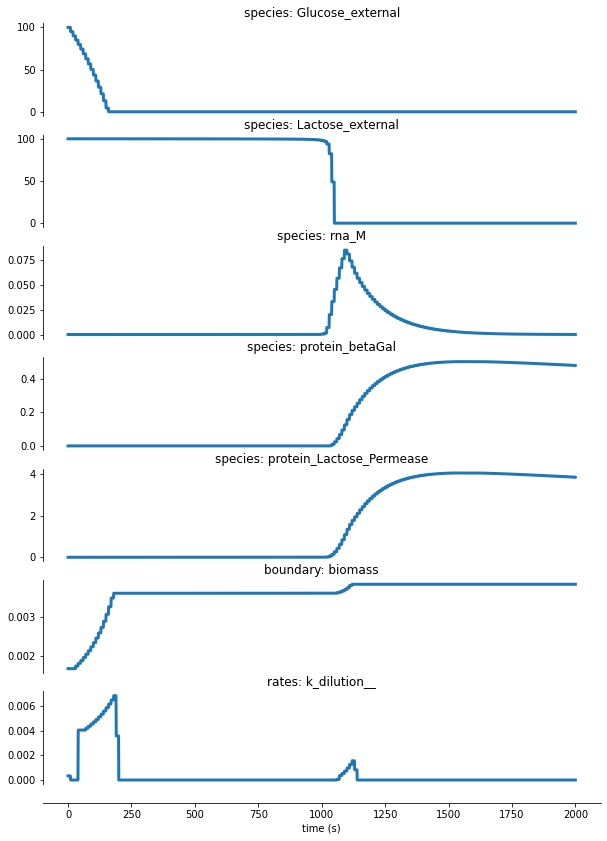

In [29]:
timeseries = bioscrape_cobra_experiment.emitter.get_timeseries()

plotted_determinsitic_bioscrape_cobra_variables = {
    'variables':[
        ('species', 'Glucose_external'), 
        ('species', 'Lactose_external'), 
        ('species', 'rna_M'), 
        ('species', 'protein_betaGal'),
        ('species', 'protein_Lactose_Permease'),
        ("boundary", "biomass"),
        ("rates", "k_dilution__")
        ]}

# plot output
variables_plot_config = {
    'filename': 'deterministic_biocobra.pdf',
    **plotted_determinsitic_bioscrape_cobra_variables,
    **plot_var_config}

fig = plot_variables(timeseries, **variables_plot_config)

## Stochastic BioscrapeCOBRA

Changes required for Stochastic Model
* New CRN Model without dilution and with initial conditions in counts instead of concentration
    * this means "k_dilution__" porting needs to removed from the topology
* BiomassDeriver converts to counts instead of concentration
* FluxDeriver run in "stochastic" mode where flux is averaged over the cobra update time-frame.

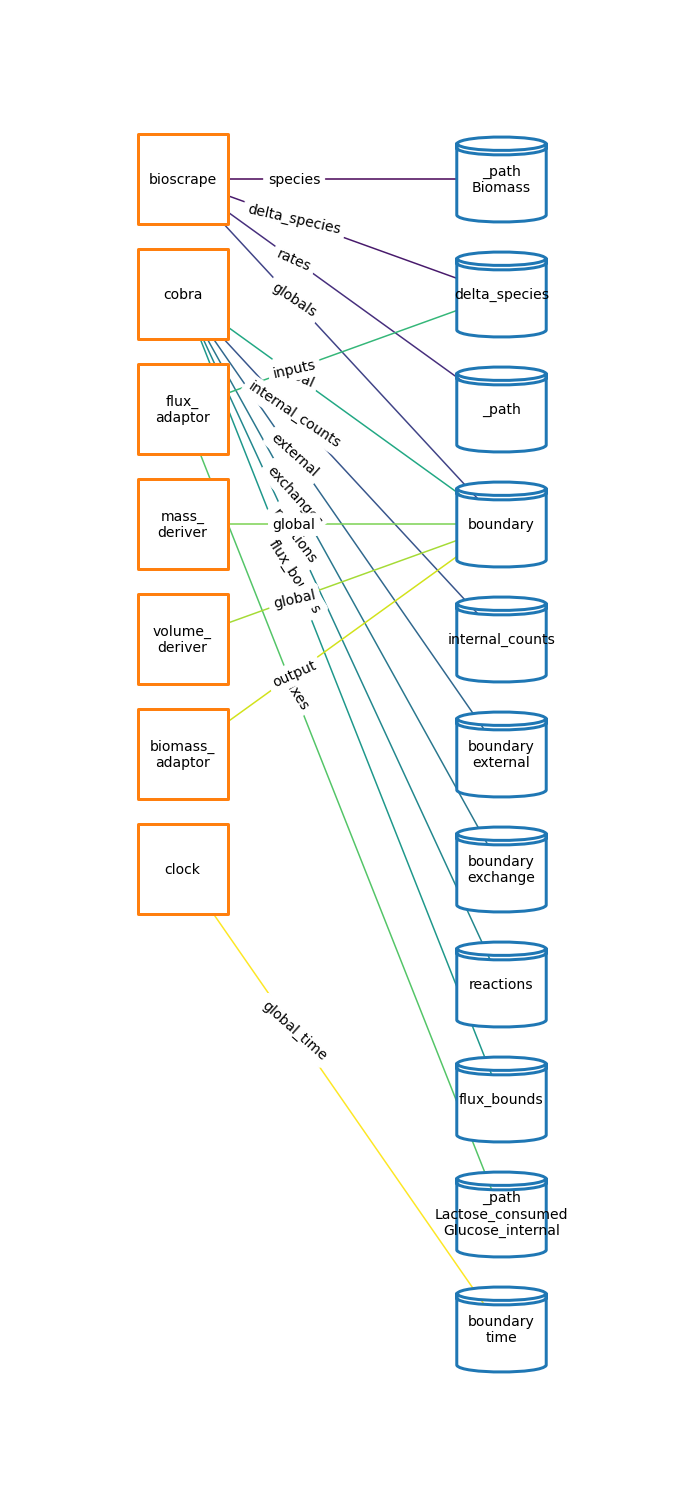

In [30]:
total_time = 2000
#stochastic_bioscrape_config = {
#            'sbml_file': 'LacOperon_stochastic.xml',
#            'stochastic': True,
#            'initial_volume': 1,
#            'internal_dt': 0.01,}

stochastic_biocobra_composer = BioscrapeCOBRA({'stochastic':True})

fig = plot_compartment_topology(stochastic_biocobra_composer)

In [127]:
initial_state = stochastic_biocobra_composer.initial_state()
initial_state['species']['Glucose_external'] = 1e6
initial_state['species']['Lactose_external'] = 1e5

# make experiment
stochastic_biocobra_composite = stochastic_biocobra_composer.generate()
stochastic_biocobra_experiment = Experiment(
    dict(
        processes=stochastic_biocobra_composite['processes'],
        topology=stochastic_biocobra_composite['topology'],
        initial_state=initial_state,))

stochastic_biocobra_experiment.update(total_time)


Experiment ID: 35e24d84-6d57-11eb-8e0b-acde48001122
Created: 02/12/2021 at 09:24:49


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:173: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])


Completed in 126.64 seconds


Writing out/stochastic_biocobra.pdf


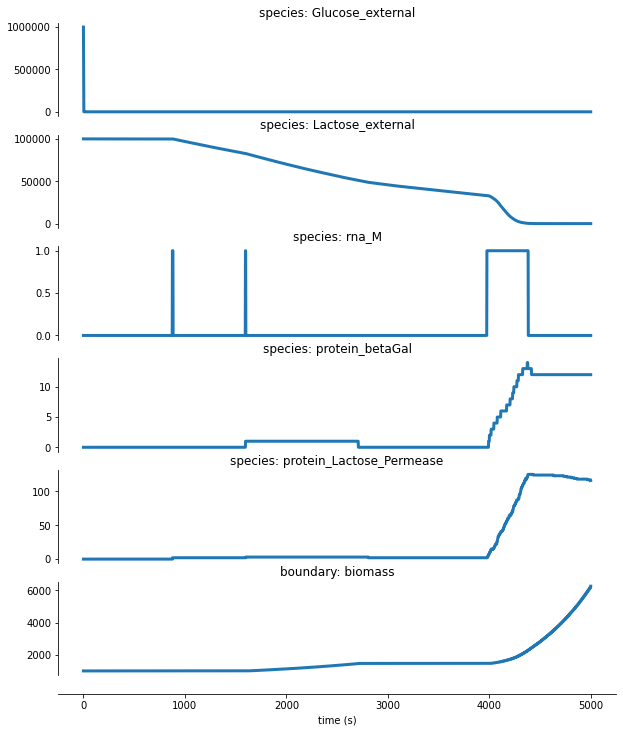

In [128]:
timeseries = stochastic_biocobra_experiment.emitter.get_timeseries()

plotted_stochastic_bioscrape_cobra_variables = {
    'variables':[
        ('species', 'Glucose_external'), 
        ('species', 'Lactose_external'), 
        ('species', 'rna_M'), 
        ('species', 'protein_betaGal'),
        ('species', 'protein_Lactose_Permease'),
        ("boundary", "biomass"),
        ]}

# plot output
variables_plot_config = {
    'filename': 'stochastic_biocobra.pdf',
    **plotted_stochastic_bioscrape_cobra_variables,
    **plot_var_config}

fig = plot_variables(timeseries, **variables_plot_config)

## Turn on Division setting

In [34]:
total_time = 2500

# division test config
agent_id = '1'
outer_path = ('agents', agent_id,)
divide_config = {
    'divide_on': True,
    'stochastic':True,
    'agent_id': agent_id,
    'agents_path': ('..', '..', 'agents',),
    'fields_path': ('..', '..', 'fields',),
    'dimensions_path': ('..', '..', 'dimensions',)}


division_composite = BioscrapeCOBRA(divide_config)

# initial state
initial_state = division_composite.initial_state()
#initial_state['species']['Glucose_external'] = 10#1e6
#initial_state['species']['Lactose_external'] = 10#1e6
initial_state = {
    'agents': {
        agent_id: initial_state}}

# run simulation
settings = {
    'experiment_id': 'division'}
division_experiment = composer_in_experiment(
    division_composite,
    outer_path=outer_path,
    initial_state=initial_state,
    settings=settings,
    )

# run the experiment 
division_experiment.update(total_time)



Experiment ID: division
Created: 02/11/2021 at 17:56:34


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:173: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:173: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:173: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/s

Completed in 113.41 seconds


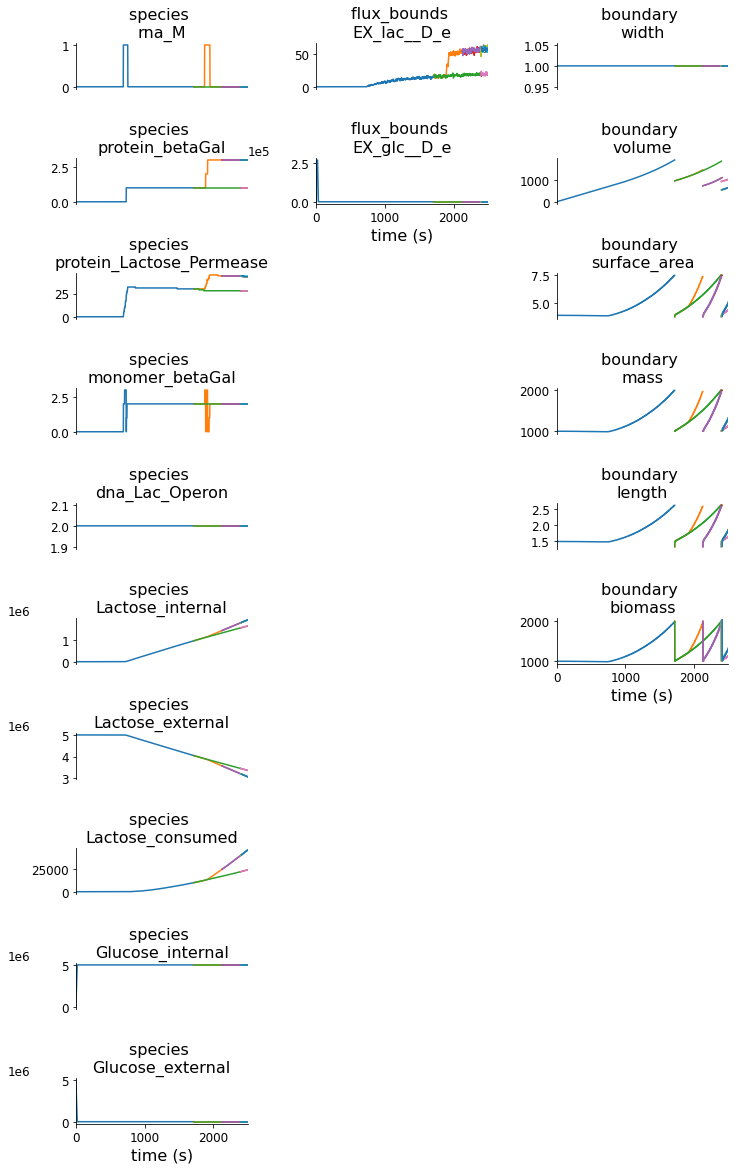

In [35]:
# extract the data
division_output = division_experiment.emitter.get_data_unitless()

# multigen plots
plot_settings = {
    'skip_paths': [
        ('external',),
        ('internal_counts',),
    ],
    'remove_zeros': True}
fig = plot_agents_multigen(
    division_output, plot_settings)


# Simulate BioscrapeCOBRA in a Spatial Environment
 * We here plug BioscrapeCOBRA into an environmental composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).

In [37]:
from vivarium_multibody.composites.lattice import Lattice, make_lattice_config

total_time = 500

# lattice environment config
BOUNDS = [20, 20]
NBINS = [10, 10]
DEPTH = 10

#Turn on spatial dynamics
spatial_config = dict(divide_config)
spatial_config["spatial_on"] = True

# initial agents state
biocobra_composer = BioscrapeCOBRA(spatial_config)
initial_state = biocobra_composer.initial_state()

# set external species TODO (Eran) -- these should be connected to the external field
initial_state['species']['Glucose_external'] = 1e6  
initial_state['species']['Lactose_external'] = 1e6
initial_state = { 
    'agents': {
        agent_id: initial_state}}

# initial fields state
initial_field_concs = {}  #initial_state['boundary']['external']
initial_field_concs.update({
    'glc__D_e': 10,
    'lcts_e': 10
})

# configure lattice compartment
lattice_config_kwargs = {
    'bounds': BOUNDS,
    'n_bins': NBINS,
    'depth': DEPTH,
    'concentrations': initial_field_concs}
lattice_config = make_lattice_config(**lattice_config_kwargs)

# declare the hierarchy
hierarchy = {
    COMPOSER_KEY: {
        'type': Lattice,
        'config': lattice_config,
    },
    'agents': {
        agent_id: {
            COMPOSER_KEY: {
                'type': BioscrapeCOBRA,
                'config': spatial_config,
            }
        }
    }
}

# make experiment with helper function compose_experiment()
experiment_settings = {
    'initial_state': initial_state,
    'experiment_id': 'spatial_environment'}
spatial_experiment = compose_experiment(
    hierarchy=hierarchy,
    settings=experiment_settings)

# run the experiment
spatial_experiment.update(total_time)



Experiment ID: spatial_environment
Created: 02/11/2021 at 18:23:22


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:173: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])


Completed in 47.59 seconds


## plot the cell states

<font color='red' size="6">
TODO: <br>
&ensp;    * Why is volume increasing when mass isn't? <br>
&ensp;    * connect Bioscrape external species to fields <br>
&ensp;    * remove the initialization line: <br>
&emsp;        initial_state['species']['Glucose_external'] = 1e6 <br>
    <br><br>
</font>

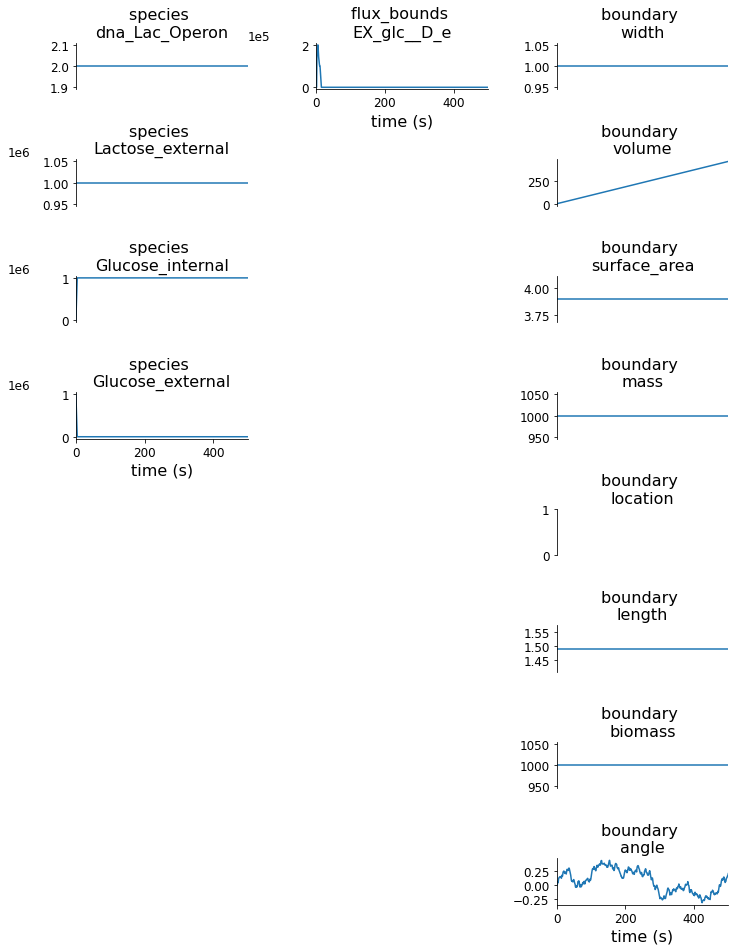

In [38]:
spatial_output = spatial_experiment.emitter.get_data_unitless()

# multigen plots
plot_settings = {
    'skip_paths': [
        ('external',),
        ('internal_counts',),
    ],
    'remove_zeros': True}
fig1 = plot_agents_multigen(spatial_output, plot_settings)


## plot the fields

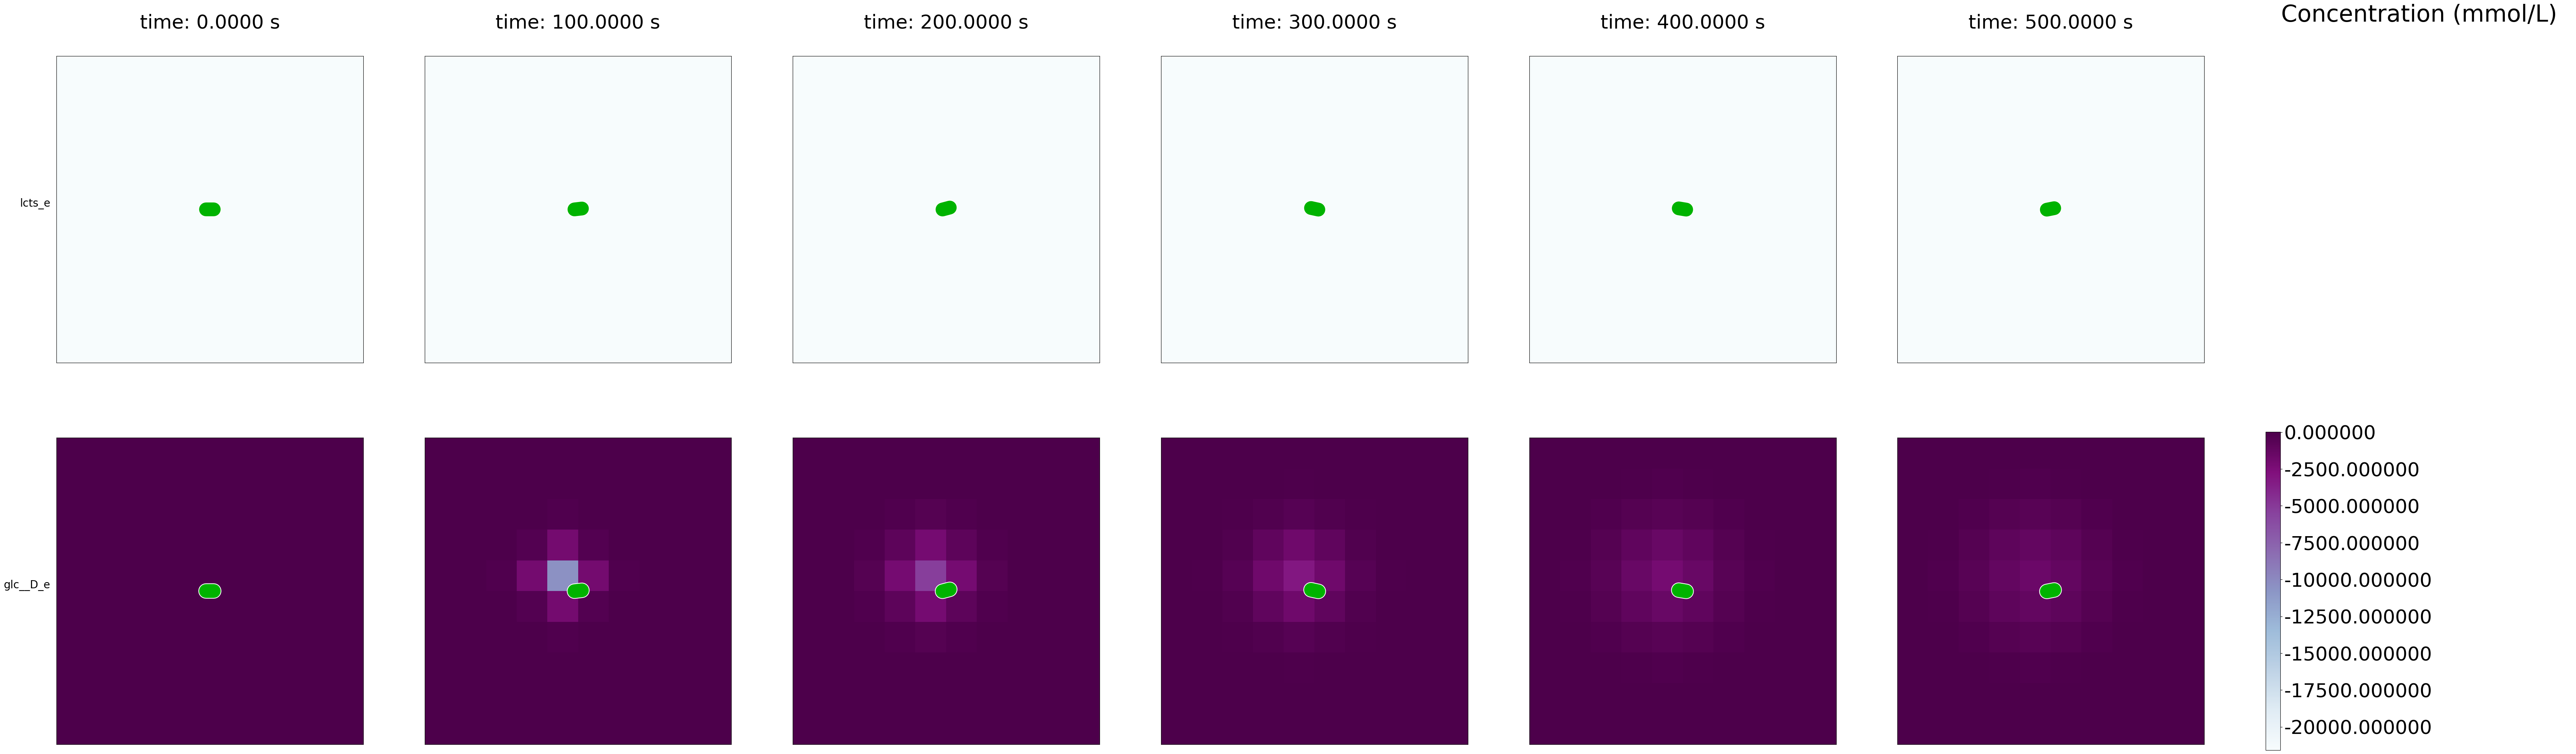

In [39]:
agents, fields = format_snapshot_data(spatial_output)
fig2 = plot_snapshots(
    bounds=BOUNDS,
    agents=agents,
    fields=fields,
    include_fields=['glc__D_e', 'lcts_e'],
    )

## plot expression

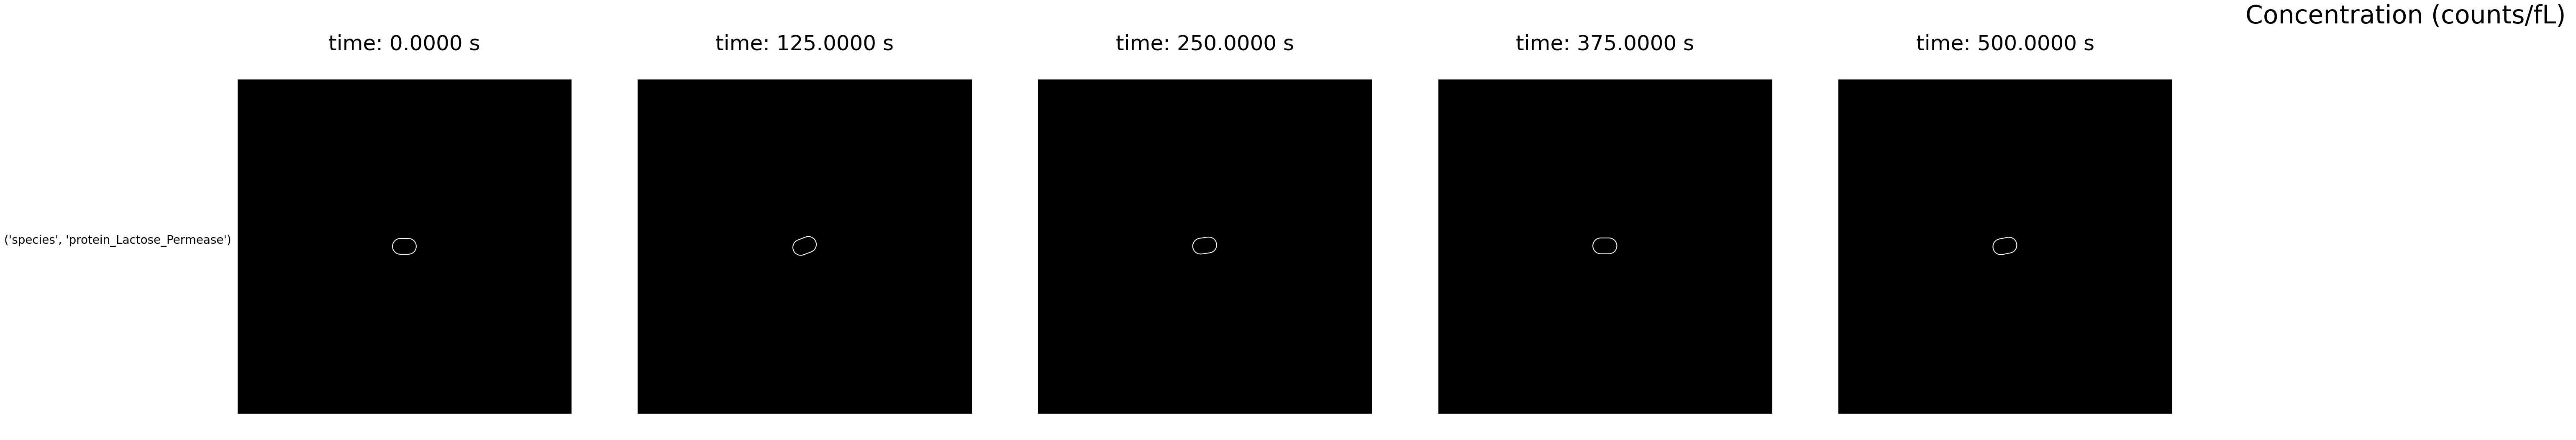

In [40]:
tags_data = {'agents': agents, 'fields': fields, 'config': {'bounds': BOUNDS}}
tags_config = {
    'n_snapshots': 5,
    'tagged_molecules': [
        ('species', 'protein_Lactose_Permease',),
    ],
    }
fig3 = plot_tags(
    data=tags_data,
    plot_config=tags_config
)